In [1]:
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
import math
import pandas as pd

In [2]:
# analyses sur une seul frame

In [3]:
with open("matrices.npy", "rb") as f :
    matrix_0 = np.load(f)
    matrix_1 = np.load(f) 

In [4]:
# Vérification de la taille de la matrice
matrix_1.shape

(200, 200)

In [5]:
# Fonction qui retourne les coordonnées des bog à partir d'un fichier .gro (contenant uniquement des informations sur les bog)
def get_bog_pos(file_gro) :
    with open(file_gro, "r") as f :
        lines = f.readlines()
    f.close()
    n = len(lines)
    lines  = lines[2:n-1]
    n = len(lines)
    pos = np.empty((n, 3))
    
    i = 0
    for line in lines :
        pos[i, 0] = line[22:28].strip()
        pos[i, 1] = line[29:36].strip()
        pos[i, 2] = line[37:43].strip()
        i += 1
        
    return pos

In [6]:
bog = get_bog_pos("BOG_1.gro")
print(bog)


[[13.047  5.076  6.2  ]
 [13.05   5.081  6.1  ]
 [13.151  4.984  6.07 ]
 ...
 [ 4.903  6.871  4.09 ]
 [ 4.957  6.729  4.11 ]
 [ 5.061  6.695  4.   ]]


In [7]:
# Récuperer les coordonnées x et y des CA des BOG
j = 16
CA_bog = np.empty((90, 2))
for i in range(90) :
    CA_bog[i, 0] = bog[j, 0]
    CA_bog[i, 1] = bog[j, 1]
    j += 24

In [8]:
# fonction qui récupère des informations sur la taille de la box et la taille des cases de la matrice
def get_info(file_txt) :
    with open(file_txt, "r") as f :
        lines = f.readlines()
    f.close()
    
    i = 0
    n = len(lines)
    infos = np.empty((n, 7))
    for line in lines : 
        infos[i, 0] = line[6:9].strip()
        infos[i, 1] = line[16:21].strip()
        infos[i, 2] = line[28:33].strip()
        infos[i, 3] = line[40:46].strip()
        infos[i, 4] = line[53:59].strip()
        infos[i, 5] = line[67:72].strip()
        infos[i, 6] = line[80:].strip()
        i += 1
    # infos = (frame, xmin, ymin, xmax, ymax, csize, rsize)
    return infos

In [9]:
infos = get_info("info.txt")
infos.ndim

2

In [10]:
# informations pour la première frame relatives à matrix_1
info_1 = infos[1,]

In [11]:
# fonction qui itère sur la matrice de pores et remplit la matrice des bords

def define_edges(matrix) :
    rlen, clen = matrix.shape
    edges = np.zeros((rlen, clen)) # création d'une matrice initialisée à zero de la même taille que la matrice des pores
    # les cases désignant les bords seront à 1
    for i in range(rlen) :
        for j in range(clen) :
            if matrix[i, j] == 0 :
                # Si i = 0
                if i == 0 :
                    if j == 0 :
                        if matrix[i+1, j] == 1  or matrix[i, j+1] == 1 :
                            edges[i, j] = 1
                    elif j == clen - 1 :
                        if matrix[i, j-1] == 1 or matrix[i+1, j] == 1 :
                            edges[i, j] = 1
                    else :
                        if matrix[i, j-1] == 1 or matrix[i+1, j] == 1 or matrix[i, j+1] == 1 :
                            edges[i, j] = 1
                # Si i = rlen -1
                elif i == rlen - 1 :
                    if j == 0 :
                        if matrix[i-1, j] == 1 or matrix[i, j+1] == 1 :
                            edges[i, j] = 1
                    elif j == clen - 1 :
                        if matrix[i, j-1] == 1 or matrix[i-1, j] == 1 :
                            edges[i,j] = 1
                    else :
                        if matrix[i, j-1] == 1  or matrix[i-1, j] == 1 or matrix[i, j+1] == 1 :
                            edges[i, j] = 1
                # Le reste des cases 
                else :
                    # Si j = 0
                    if j == 0 :
                        if matrix[i-1, j] == 1 or matrix[i, j+1] == 1 or matrix[i+1, j] == 1 :
                            edges[i, j] = 1
                    # Si j = clen - 1
                    elif j == clen -1 :
                        if matrix[i-1, j] == 1 or matrix[i, j-1] == 1 or matrix[i+1, j] == 1 :
                            edges[i, j] == 1
                    # Les cases entourées de 4 cases
                    else :
                        if matrix[i-1, j] == 1 or matrix[i+1, j] == 1 or matrix[i, j-1] == 1 or matrix[i, j+1] == 1 :
                            edges[i, j] = 1
    edges = np.flipud(edges)
    return edges

In [12]:
# Localisation des bords des pores pour la matrice 1
edges_1 = define_edges(matrix_1)

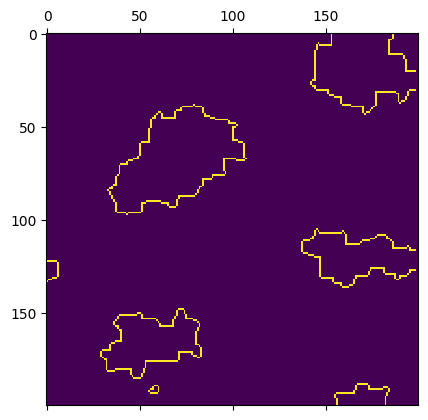

In [13]:
plt.matshow(edges_1)

In [14]:
# Placer les CA de bog dans une matrice, à partir de leurs coordonnées x et y, on leur désigne une case (un indice de ligne i et de colonne j)
## xmin et max ymin et max
xmin, ymin, xmax, ymax = info_1[1:5]
print(xmin, ymin, xmax, ymax)

## Définir l'intervalle
x_axis = xmax - xmin # Pour l'axe des x
y_axis = ymax - ymin # Pour l'axe des y
print(x_axis, y_axis)

## Remplir la matrice 
bog_matrix = np.zeros((200, 200))
for raw in CA_bog :
    i = min(math.floor(raw[1]*(200/y_axis)), 199)
    j = min(math.floor(raw[0]*(200/x_axis)), 199)
    bog_matrix[i, j] = 1
bog_matrix = np.flipud(bog_matrix)

0.001 0.001 13.599 13.597
13.598 13.596


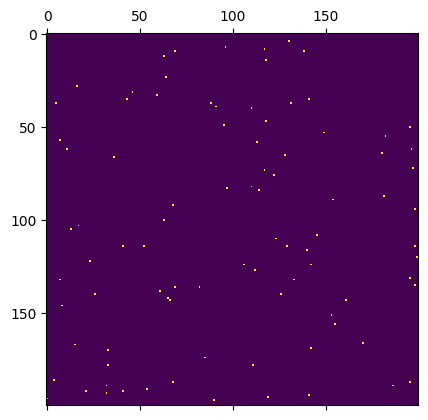

In [15]:
plt.matshow(bog_matrix)

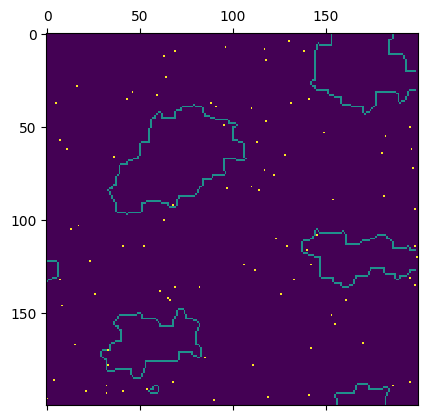

In [16]:
# Fusionner la matrice de pores et la matrice de bog

bog_pores = edges_1

for i in range(200) :
    for j in range(200) :
        if bog_matrix[i,j] == 1 :
            bog_pores[i,j] = 2
plt.matshow(bog_pores)

In [17]:
# Récupérer les indices de cases indiquant une case à 1
def get_coordinates(matrix) :
    rlen, clen = matrix.shape
    coors = []
    for i in range(rlen) :
        for j in range(clen) :
            if matrix[i, j] == 1 :
                coors.append([i,j])
    coors = np.array(coors)
    return coors

In [18]:
# Coordonnées des pores dans la matrice
edges_coor = get_coordinates(edges_1)
edges_coor.shape

(809, 2)

In [19]:
edges_coor

array([[  0, 153],
       [  0, 186],
       [  1, 153],
       ...,
       [198, 182],
       [199, 156],
       [199, 182]])

In [20]:
# Vérifier que les cases avec ces coordonnées sont à 1 dans la matrice de bords
flag =  True 
for raw in edges_coor :
    if edges_1[raw[0], raw[1]] == 0 :
        flag = False
if flag == False :
    print("Erreur")
else :
    print("Vérifiée !")

Vérifiée !


In [21]:
# Pour les bog
bog_coor = get_coordinates(bog_matrix)
bog_coor.shape

(90, 2)

In [22]:
# Vérifier que les cases avec ces coordonnées sont à 1 dans la matrice d bog
flag =  True 
for raw in bog_coor :
    if bog_matrix[raw[0], raw[1]] == 0 :
        flag = False
if flag == False :
    print("Erreur")
else :
    print("Vérifiée !")

Vérifiée !


In [23]:
# vérifier le nombre de 1 dans la matrice de bords et la matrice de bog, comparer aux dimensions des array des coordonnées 
nb_pores = 0
nb_bog = 0
for i in range(200) : 
    for j in range(200) : 
        if edges_1[i, j] == 1 :
            nb_pores += 1
        if bog_matrix[i, j] == 1 :
            nb_bog += 1
print("nombre de cases à 1 dans la matrice des bords est : ", nb_pores)
print("nombre de cases à 1 dans la matrice des bog est : ", nb_bog)

nombre de cases à 1 dans la matrice des bords est :  809
nombre de cases à 1 dans la matrice des bog est :  90


In [24]:
# Calcul des distances entre les bog et les bords à partir des indices de cases comme coordonnées

In [25]:
# Fonction qui calcule la distance eucledienne entre deux points
def dist_euc(point1, point2) : 
    dist = math.sqrt((point2[0]-point1[0])**2+(point2[1]-point1[1])**2)
    return dist

In [26]:
# Distances à partir des indices de lignes et de colonnes comme coordonnées 
dicts = {}
bog_number = 1
for i in bog_coor :
    dist_min = dist_euc(i, edges_coor[0])
    closest_point = edges_coor[0]
    dict_name = f"bog_{bog_number}"
    for j in edges_coor :
        dist = dist_euc(j, i)
        if dist <= dist_min :
            dist_min = dist
            closest_point = j
    dict_tmp = {}
    dict_tmp["dist_min"] = dist_min
    dict_tmp["closest_point"] = closest_point
    dicts[dict_name] = dict_tmp
    bog_number +=1

In [27]:
dicts

{'bog_1': {'dist_min': 14.866068747318506, 'closest_point': array([  9, 144])},
 'bog_2': {'dist_min': 34.539832078341085, 'closest_point': array([39, 83])},
 'bog_3': {'dist_min': 27.018512172212592, 'closest_point': array([  9, 144])},
 'bog_4': {'dist_min': 30.265491900843113, 'closest_point': array([39, 73])},
 'bog_5': {'dist_min': 6.0, 'closest_point': array([  9, 144])},
 'bog_6': {'dist_min': 28.792360097775937, 'closest_point': array([39, 73])},
 'bog_7': {'dist_min': 26.0, 'closest_point': array([ 14, 144])},
 'bog_8': {'dist_min': 18.35755975068582, 'closest_point': array([39, 73])},
 'bog_9': {'dist_min': 43.86342439892262, 'closest_point': array([46, 56])},
 'bog_10': {'dist_min': 17.69180601295413, 'closest_point': array([44, 58])},
 'bog_11': {'dist_min': 9.055385138137417, 'closest_point': array([42, 60])},
 'bog_12': {'dist_min': 17.029386365926403, 'closest_point': array([46, 56])},
 'bog_13': {'dist_min': 6.4031242374328485,
  'closest_point': array([ 30, 145])},
 'b

In [28]:
close_points = []
for key in dicts :
    close_points.append(dicts[key]["closest_point"])
close_points = np.array(close_points)
close_points

array([[  9, 144],
       [ 39,  83],
       [  9, 144],
       [ 39,  73],
       [  9, 144],
       [ 39,  73],
       [ 14, 144],
       [ 39,  73],
       [ 46,  56],
       [ 44,  58],
       [ 42,  60],
       [ 46,  56],
       [ 30, 145],
       [ 71,  39],
       [ 40,  84],
       [ 27, 142],
       [ 45,  90],
       [ 49, 102],
       [ 49, 102],
       [ 46,  95],
       [ 37, 190],
       [ 38, 159],
       [ 42, 173],
       [ 71,  39],
       [ 59, 106],
       [ 71,  39],
       [ 37, 190],
       [ 43, 171],
       [ 67, 107],
       [ 70,  40],
       [ 37, 190],
       [ 67, 107],
       [ 67, 107],
       [ 68, 106],
       [ 76,  95],
       [ 68, 106],
       [108, 181],
       [106, 159],
       [ 93,  68],
       [114, 194],
       [ 93,  66],
       [ 95,  37],
       [122,   5],
       [108, 144],
       [112, 137],
       [ 97,  43],
       [ 96,  50],
       [114, 137],
       [116, 198],
       [118, 140],
       [116, 198],
       [123,   6],
       [117,

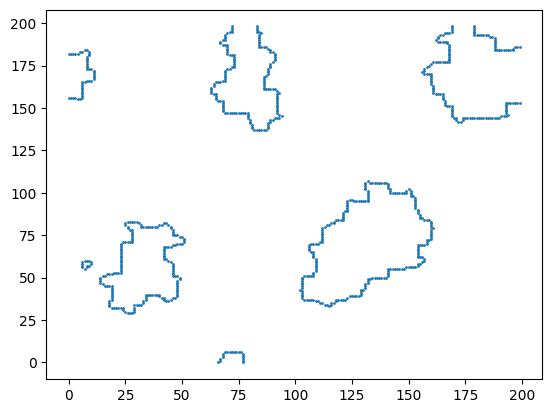

In [29]:
tata = np.flipud(edges_1)
toto = get_coordinates(tata)
plt.scatter(toto[:, 0], toto[:, 1], s = 1)

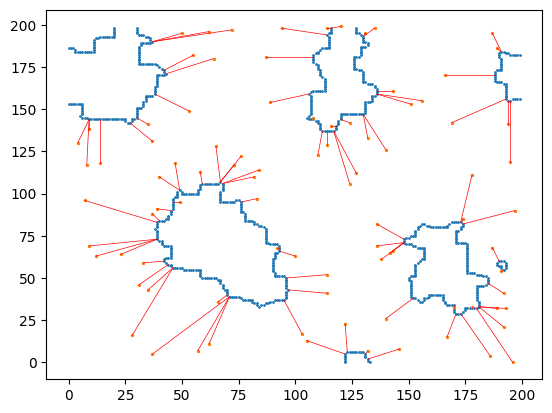

In [30]:
plt.scatter(edges_coor[:, 0], edges_coor[:, 1], s = 1)
plt.scatter(bog_coor[:, 0], bog_coor[:, 1], s = 2)
plt.plot([bog_coor[:, 0], close_points[:, 0]], [bog_coor[:, 1], close_points[:, 1]], "r-", lw = 0.5)

In [31]:
#  Calcul des distances entre les bog et les bords à partir des coordonnées estimées des boors et des vraies coordonnées de bog

In [32]:
# estimer les coordonnées des pores à partir des cases
xmin, ymin, xmax, ymax, csize, rsize = info_1[1:]
print(xmin, ymin, xmax, ymax, csize, rsize)

0.001 0.001 13.599 13.597 0.068 0.068


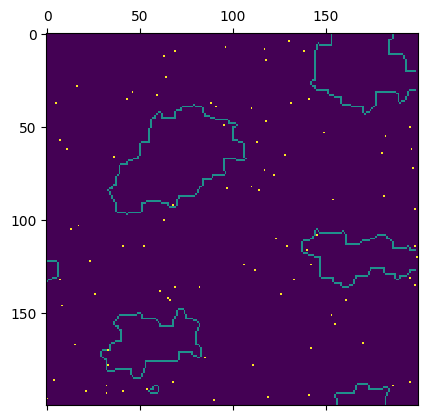

In [33]:
plt.matshow(edges_1)

In [34]:
# L'estimation des coordonnées de bords doit se faire à partir de la matrice initial non tournée

n, m = edges_coor.shape
edges_estm = np.zeros((n, m))
i = 0
matrix = np.flipud(edges_1)
edges1_index = get_coordinates(matrix)
for raw in edges1_index :
    x = ((raw[1]*x_axis)/200) + rsize/2
    y = ((raw[0]*y_axis)/200) + csize/2
    edges_estm[i,0] = x
    edges_estm[i,1] = y
    i += 1
edges_estm

array([[10.64044,  0.034  ],
       [12.40818,  0.034  ],
       [10.64044,  0.10198],
       ...,
       [12.68014, 13.49404],
       [10.43647, 13.56202],
       [12.68014, 13.56202]])

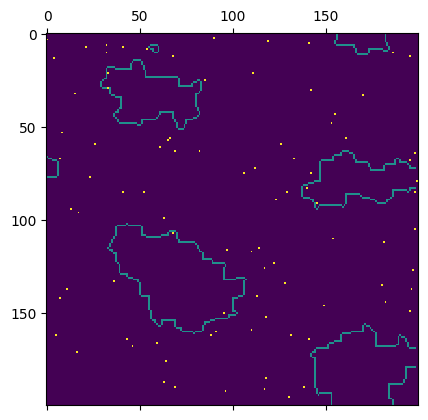

In [35]:
plt.matshow(np.flipud(edges_1))

In [36]:
edges_estm.shape

(809, 2)

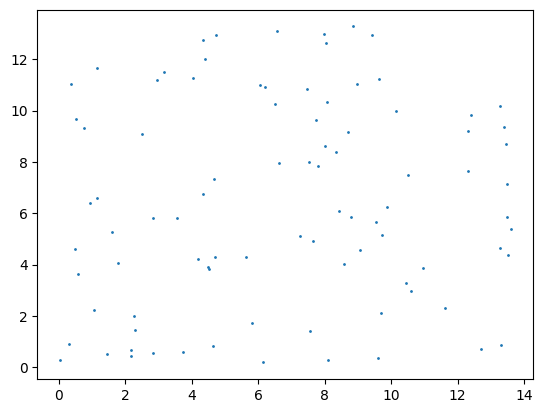

In [37]:
# plt.scatter(edges_estm[:, 0], edges_estm[:, 1], s = 1)
plt.scatter(CA_bog[:, 0], CA_bog[:, 1], s = 1)

In [38]:
# les informations pour les distances minimales et le point le plus proche à chaque bog seront enregistré dans le dictionnaire dicts1
dicts1 = {}
bog_number = 1
for i in CA_bog :
    dist_min = dist_euc(i, edges_estm[0])
    closest_point = edges_estm[0]
    dict_name = f"bog_{bog_number}"
    for j in edges_estm :
        dist = dist_euc(j, i)
        if dist <= dist_min :
            dist_min = dist
            closest_point = j
    dict_tmp = {}
    dict_tmp["dist_min"] = dist_min
    dict_tmp["closest_point"] = closest_point
    dicts1[dict_name] = dict_tmp # au sein du dictionnaire il y aura un dictionnaire pour chaque bog, qui a comme clé le numéro du bog
    bog_number +=1

In [39]:
dicts1

{'bog_1': {'dist_min': 0.13786917458228157,
  'closest_point': array([13.15607,  4.72462])},
 'bog_2': {'dist_min': 1.481018508763479,
  'closest_point': array([2.54963, 7.10392])},
 'bog_3': {'dist_min': 0.2983126480724548,
  'closest_point': array([13.49602,  5.67634])},
 'bog_4': {'dist_min': 0.9804742793668798,
  'closest_point': array([10.57245,  0.3739 ])},
 'bog_5': {'dist_min': 0.6025300982523609,
  'closest_point': array([3.22953, 0.98572])},
 'bog_6': {'dist_min': 1.1793557512472645,
  'closest_point': array([2.61762, 3.22906])},
 'bog_7': {'dist_min': 1.4271608628672525,
  'closest_point': array([12.34019,  6.22018])},
 'bog_8': {'dist_min': 1.0931918772109483,
  'closest_point': array([ 6.96898, 10.231  ])},
 'bog_9': {'dist_min': 1.9392611512893245,
  'closest_point': array([ 4.99727, 10.9108 ])},
 'bog_10': {'dist_min': 0.9658217047157319,
  'closest_point': array([10.02853,  4.72462])},
 'bog_11': {'dist_min': 1.3629464309355661,
  'closest_point': array([13.22406,  5.81

In [40]:
# On récupère le point le plus proche à chaque bog
close_points1 = []
for key in dicts1 :
    close_points1.append(dicts1[key]["closest_point"])
close_points1 = np.array(close_points1)
close_points1

array([[13.15607,  4.72462],
       [ 2.54963,  7.10392],
       [13.49602,  5.67634],
       [10.57245,  0.3739 ],
       [ 3.22953,  0.98572],
       [ 2.61762,  3.22906],
       [12.34019,  6.22018],
       [ 6.96898, 10.231  ],
       [ 4.99727, 10.9108 ],
       [10.02853,  4.72462],
       [13.22406,  5.8123 ],
       [ 2.00571,  1.93744],
       [ 3.4335 ,  7.03594],
       [10.02853,  4.72462],
       [ 4.86129,  3.50098],
       [ 5.67717,  1.80148],
       [ 2.20968,  2.00542],
       [ 2.95757,  6.96796],
       [ 7.24094,  8.93938],
       [ 4.1134 , 10.70686],
       [ 6.49305,  8.39554],
       [ 3.77345,  0.50986],
       [ 5.60918,  1.7335 ],
       [12.9521 , 11.04676],
       [10.84441, 10.97878],
       [13.15607,  4.72462],
       [ 7.30893,  9.00736],
       [ 9.82456, 12.6103 ],
       [ 2.27767,  1.25764],
       [ 2.68561,  8.73544],
       [11.66029, 10.63888],
       [11.79627, 10.70686],
       [ 4.99727,  3.50098],
       [ 9.82456,  5.40442],
       [10.572

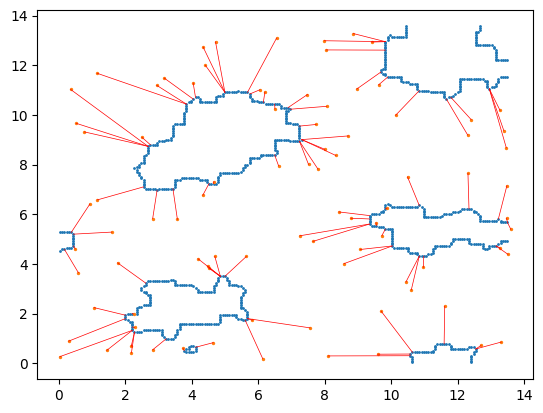

In [41]:
# représentation des pores, bog, et liaison de chaque bog à son point le plus proche
plt.scatter(edges_estm[:, 0], edges_estm[:, 1], s = 1)
plt.scatter(CA_bog[:, 0], CA_bog[:, 1], s = 2)
plt.plot([CA_bog[:, 0], close_points1[:, 0]], [CA_bog[:, 1], close_points1[:, 1]], "r-", lw = 0.5)
plt.show()

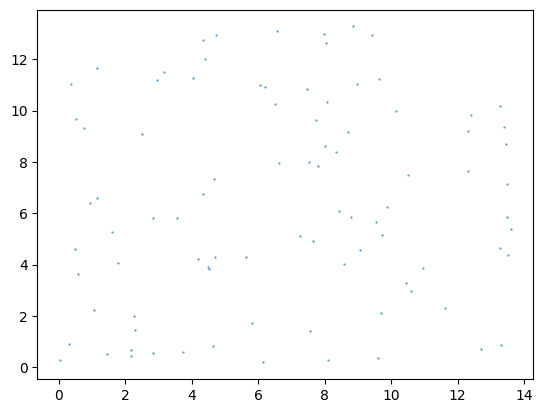

In [42]:
plt.scatter(CA_bog[:, 0], CA_bog[:, 1], s=.2)


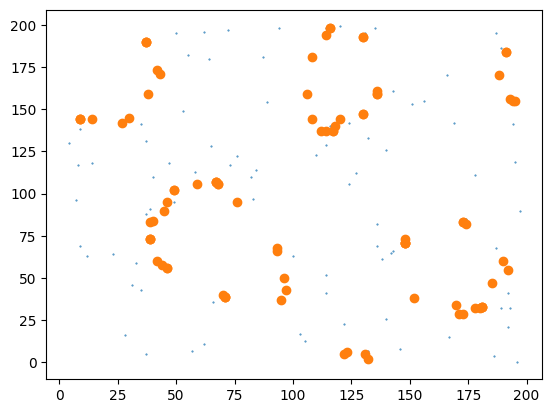

In [43]:
plt.scatter(bog_coor[:, 0], bog_coor[:, 1], s=.2)
plt.scatter(close_points[:, 0], close_points[:, 1])

In [44]:
bog_coor[0]

array([  4, 130])

In [45]:
close_points[0]

array([  9, 144])

In [46]:
np.linalg.norm(bog_coor[0] - close_points[0])

14.866068747318506

In [47]:
dist = np.zeros(90)
for i, c in enumerate(bog_coor):
    dist[i] = np.linalg.norm(c - close_points[i])

In [48]:
a = np.argwhere(dist < 30)

In [49]:
dist[a]

array([[14.86606875],
       [27.01851217],
       [ 6.        ],
       [28.7923601 ],
       [26.        ],
       [18.35755975],
       [17.69180601],
       [ 9.05538514],
       [17.02938637],
       [ 6.40312424],
       [ 5.        ],
       [14.86606875],
       [ 6.08276253],
       [12.04159458],
       [16.1245155 ],
       [ 3.        ],
       [13.92838828],
       [18.02775638],
       [15.8113883 ],
       [ 7.07106781],
       [29.41088234],
       [25.70992026],
       [22.84731932],
       [21.09502311],
       [ 5.65685425],
       [11.66190379],
       [17.49285568],
       [14.56021978],
       [ 7.28010989],
       [17.88854382],
       [21.        ],
       [17.72004515],
       [ 1.        ],
       [20.39607805],
       [ 7.61577311],
       [21.54065923],
       [18.78829423],
       [ 1.        ],
       [14.14213562],
       [17.11724277],
       [18.11077028],
       [ 8.        ],
       [ 2.        ],
       [ 2.        ],
       [ 4.12310563],
       [17

In [50]:
processed_array = np.where(dist < 30, 1, 0)
print(processed_array)

[1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1]


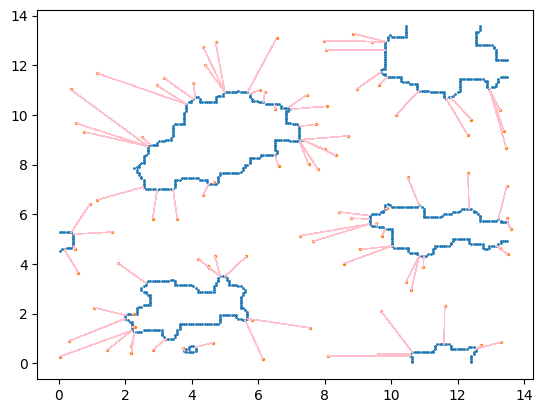

In [51]:
plt.scatter(edges_estm[:, 0], edges_estm[:, 1], s = 1)
plt.scatter(CA_bog[:, 0], CA_bog[:, 1], s = 2)
for value in processed_array:
        plt.plot([CA_bog[:, 0], close_points1[:, 0]], [CA_bog[:, 1], close_points1[:, 1]], lw = 0.5, color = 'pink')        
plt.show()

In [52]:
import MDAnalysis as mda

# Load the .gro file
start = mda.Universe("startl12.gro")
five= mda.Universe("500nsl12.gro")
ten = mda.Universe("1000nsl12.gro")
fifteen = mda.Universe("1500nsl12.gro")
twenty = mda.Universe("2000nsl12.gro")

# Accessing atom positions
positions_start = start.atoms.positions
positions_five = five.atoms.positions
positions_ten = ten.atoms.positions
positions_fifteen = fifteen.atoms.positions
positions_twenty = twenty.atoms.positions


In [53]:
# Fonction qui retourne les coordonnées des bog à partir d'un fichier .gro (contenant uniquement des informations sur les bog)
def get_bog_position(file_gro) :
    with open(file_gro, "r") as f :
        lines = f.readlines()
    f.close()
    n = len(lines)
    lines  = lines[0:n]
    n = len(lines)
    pos = np.empty((n, 3))
    
    i = 0
    for line in lines :
        pos[i, 0] = line[22:28].strip()
        pos[i, 1] = line[29:36].strip()
        pos[i, 2] = line[37:43].strip()
        i += 1
        
    return pos

In [54]:

gro_file = "startl12.gro"
with open(gro_file, "r") as file:
    lines = file.readlines()
bog_molecule_lines = []

collect = False

for line in lines:
    if "830BOG" in line: 
        collect = True
    if collect and "BOG" in line:  
        bog_molecule_lines.append(line.strip() + "\n")  
    elif collect and "BOG" not in line:  
        break

with open("bog_molecules_start.gro", "w") as output_file:
  output_file.writelines(bog_molecule_lines)
start_bog = get_bog_position("bog_molecules_start.gro")
start_bog

array([[0.795, 5.489, 7.501],
       [0.706, 5.517, 7.463],
       [0.72 , 5.618, 7.362],
       ...,
       [0.475, 3.487, 5.587],
       [0.616, 3.43 , 5.604],
       [0.67 , 3.454, 5.463]])

In [55]:

gro_file = "500nsl12.gro" 
with open(gro_file, "r") as file:
    lines = file.readlines()

bog_molecule_lines = []

collect = False

for line in lines:
    if "830BOG" in line: 
        collect = True
    if collect and "BOG" in line:  
        bog_molecule_lines.append(line.strip() + "\n")  
    elif collect and "BOG" not in line:  
        break

with open("bog_molecules_500.gro", "w") as output_file:
  output_file.writelines(bog_molecule_lines)
five_bog = get_bog_position("bog_molecules_500.gro")
five_bog


array([[0.924, 0.736, 6.816],
       [0.855, 0.76 , 6.748],
       [0.761, 0.838, 6.824],
       ...,
       [0.801, 3.164, 6.114],
       [0.83 , 3.053, 6.013],
       [0.926, 3.102, 5.905]])

In [56]:
 
gro_file = "1000nsl12.gro"
with open(gro_file, "r") as file:
    lines = file.readlines()

bog_molecule_lines = []

collect = False

for line in lines:
    if "830BOG" in line: 
        collect = True
    if collect and "BOG" in line:  
        bog_molecule_lines.append(line.strip() + "\n")  
    elif collect and "BOG" not in line:  
        break

with open("bog_molecules_1000.gro", "w") as output_file:
  output_file.writelines(bog_molecule_lines)
ten_bog = get_bog_position("bog_molecules_1000.gro")
ten_bog


array([[0.968, 6.33 , 7.746],
       [0.913, 6.246, 7.75 ],
       [0.943, 6.18 , 7.626],
       ...,
       [0.151, 7.956, 4.727],
       [0.252, 7.874, 4.646],
       [0.39 , 7.873, 4.712]])

In [57]:
gro_file = "1500nsl12.gro"
with open(gro_file, "r") as file:
    lines = file.readlines()

bog_molecule_lines = []

collect = False

for line in lines:
    if "830BOG" in line: 
        collect = True
    if collect and "BOG" in line:  
        bog_molecule_lines.append(line.strip() + "\n")  
    elif collect and "BOG" not in line:  
        break

with open("bog_molecules_1500.gro", "w") as output_file:
  output_file.writelines(bog_molecule_lines)
fifteen_bog = get_bog_position("bog_molecules_1500.gro")
fifteen_bog

array([[0.659, 0.132, 2.711],
       [0.732, 0.086, 2.762],
       [0.824, 0.183, 2.816],
       ...,
       [0.409, 3.358, 5.574],
       [0.367, 3.497, 5.526],
       [0.218, 3.529, 5.513]])

In [58]:
gro_file = "2000nsl12.gro" 
with open(gro_file, "r") as file:
    lines = file.readlines()

bog_molecule_lines = []

collect = False

for line in lines:
    if "830BOG" in line: 
        collect = True
    if collect and "BOG" in line:  
        bog_molecule_lines.append(line.strip() + "\n")  
    elif collect and "BOG" not in line:  
        break


with open("bog_molecules_2000.gro", "w") as output_file:
  output_file.writelines(bog_molecule_lines)
twenty_bog = get_bog_position("bog_molecules_2000.gro")


In [59]:
j = 16
CA_five_bog = np.empty((90, 2))
for i in range(90) :
    CA_five_bog[i, 0] = five_bog[j, 0]
    CA_five_bog[i, 1] = five_bog[j, 1]
    j += 24
np.set_printoptions(suppress=True, precision=3)

In [60]:
j=16
CA_ten_bog = np.empty((90, 2))
for i in range(90) :
    CA_ten_bog[i, 0] = ten_bog[j, 0]
    CA_ten_bog[i, 1] = ten_bog[j, 1]
    j += 24
np.set_printoptions(suppress=True, precision=3)

In [61]:
j=16
CA_fifteen_bog = np.empty((90, 2))
for i in range(90) :
    CA_fifteen_bog[i, 0] = fifteen_bog[j, 0]
    CA_fifteen_bog[i, 1] = fifteen_bog[j, 1]
    j += 24
np.set_printoptions(suppress=True, precision=3)

In [62]:
j=16
CA_twenty_bog = np.empty((90, 2))
for i in range(90) :
    CA_twenty_bog[i, 0] = twenty_bog[j, 0]
    CA_twenty_bog[i, 1] = twenty_bog[j, 1]
    j += 24
np.set_printoptions(suppress=True, precision=3)

In [63]:
j = 16
CA_start_bog = np.empty((90, 2))
for i in range(90) :
    CA_start_bog[i, 0] = start_bog[j, 0]
    CA_start_bog[i, 1] = start_bog[j, 1]
    j += 24
np.set_printoptions(suppress=True, precision=3)

In [64]:
dist_start= np.zeros(90)
for i, c in enumerate(CA_start_bog):
    dist_start[i] = np.linalg.norm(c - close_points1[i])
# a = np.argwhere(dist_start < 30)
# dist_start[a]
# processed_array_1 = np.where(dist_start < 30, 1, 0)
# print(processed_array_1)
dist_start

array([12.605,  4.777, 13.026, 10.55 ,  3.837,  2.426, 13.553, 10.935,
        8.53 , 10.269, 13.353,  1.154,  4.802,  9.358,  5.636,  5.327,
        2.279,  3.254,  9.95 , 11.022,  6.302,  8.133,  5.596, 15.728,
       13.427, 12.864, 10.907, 14.039,  2.151,  2.023, 11.29 , 11.149,
        6.084,  9.247, 13.764, 11.711,  5.398,  2.896,  7.74 , 11.244,
        9.118,  3.692,  7.924,  6.795,  6.795, 13.188, 11.987,  7.55 ,
        7.619,  9.004,  9.745,  8.66 ,  4.85 ,  5.567,  4.781, 11.635,
        1.775, 11.131,  4.627,  9.85 ,  6.482, 11.283,  6.933,  9.954,
        9.912, 11.931,  3.677,  9.891,  4.102,  9.965, 11.9  , 10.888,
       14.344, 12.531, 12.854,  9.468,  5.305,  0.227,  2.527, 10.024,
        4.7  , 13.985,  9.327, 10.113, 10.088, 15.298,  2.308,  6.146,
        8.731,  5.897])

In [65]:
dist_five= np.zeros(90)
for i, c in enumerate(CA_five_bog):
    dist_five[i] = np.linalg.norm(c - close_points1[i])
dist_five
# a = np.argwhere(dist_five < 30)
# dist_five[a]
# processed_array_2 = np.where(dist_five < 30, 1, 0)
# print(processed_array_2)

array([13.27 ,  2.906, 13.543, 10.752,  3.61 ,  2.869, 11.562, 10.613,
        6.519,  9.702, 13.419,  2.137,  3.798, 10.342,  7.821,  8.48 ,
        2.75 ,  3.043,  9.351,  5.012,  8.466,  4.437,  5.36 , 12.544,
       13.919, 13.797, 10.195, 14.769,  6.805,  2.59 , 13.494, 12.178,
        6.352, 10.249, 13.561, 13.492,  6.585,  2.397,  8.448, 10.661,
       10.252,  4.319,  9.924,  1.414,  2.934, 13.58 , 10.836,  5.777,
        6.993, 10.209,  9.94 , 10.474,  9.588,  6.782,  4.096, 10.925,
        2.487, 14.885,  5.701,  9.614, 11.937, 10.159,  1.729,  8.58 ,
        9.3  , 14.166,  4.57 ,  8.635,  5.224, 10.191, 11.479, 14.056,
       14.797, 12.632, 12.704,  8.694,  2.22 ,  2.75 ,  0.099, 10.909,
        5.264, 10.949,  5.327, 10.156,  6.824, 15.08 ,  2.445, 10.047,
        7.329,  5.871])

In [66]:
dist_ten= np.zeros(90)
for i, c in enumerate(CA_ten_bog):
    dist_ten[i] = np.linalg.norm(c - close_points1[i])
dist_ten
# a = np.argwhere(dist_ten < 30)
# dist_ten[a]
# processed_array_3 = np.where(dist_ten < 30, 1, 0)
# print(processed_array_3)

array([12.297,  6.548, 13.016, 10.368,  8.92 ,  2.958, 13.028,  6.283,
       10.805,  9.43 , 13.907,  1.819,  4.794,  9.583,  5.336,  5.639,
        3.447,  5.488,  8.397,  4.095,  6.541,  8.945,  6.494, 14.932,
       13.261, 12.854,  8.62 , 14.399,  3.403,  5.549, 13.327, 15.055,
        5.214,  9.91 ,  9.918, 11.519,  7.92 ,  2.407,  9.26 , 10.776,
        9.942,  4.839,  9.209,  3.937,  3.146, 13.355,  9.778,  4.216,
        9.426,  5.911,  8.628,  9.504, 11.081,  2.613,  3.149, 11.302,
        2.102, 11.28 ,  4.105, 10.255,  8.715, 10.291,  2.246, 10.013,
        6.776, 12.351,  5.289,  9.437,  8.086, 10.723,  8.626, 11.326,
       13.65 , 12.32 , 14.644,  9.504,  4.352,  4.55 ,  0.512, 10.791,
        4.784, 12.338,  8.78 , 14.334,  6.483, 15.124,  2.913,  9.241,
        7.91 ,  4.033])

In [67]:
dist_fifteen= np.zeros(90)
for i, c in enumerate(CA_fifteen_bog):
    dist_fifteen[i] = np.linalg.norm(c - close_points1[i])
dist_fifteen
# a = np.argwhere(dist_fifteen < 30)
# dist_fifteen[a]
# processed_array_5 = np.where(dist_fifteen < 30, 1, 0)
# print(processed_array_5)

array([13.866,  7.004, 12.742, 13.22 ,  7.494,  4.808, 13.039, 11.867,
        8.091,  9.525, 13.972,  1.676,  7.205, 10.336,  5.244,  6.443,
        1.709,  4.898,  7.15 ,  9.843,  5.938,  4.985,  8.065, 15.849,
       11.974, 13.409,  7.036,  9.499,  2.425,  4.116, 12.387, 15.198,
        4.579,  9.822, 10.626, 14.421,  4.277,  5.139,  6.989, 10.626,
        9.91 ,  7.767,  9.018,  6.04 ,  5.763, 14.533, 10.688,  4.859,
       10.572, 10.633,  8.639, 10.293,  8.955,  5.388,  6.361, 10.515,
        1.291, 12.762,  4.63 , 10.648,  6.693, 11.38 ,  2.302,  9.15 ,
        9.453, 13.849,  1.562, 10.221,  7.707, 11.308, 10.468, 11.909,
       13.428, 15.478, 13.303,  8.501,  6.931,  3.981,  1.206, 10.473,
        5.311,  9.826,  5.638, 13.814,  3.713, 12.334,  2.419,  9.017,
        6.834,  5.734])

In [68]:
dist_twenty= np.zeros(90)
for i, c in enumerate(CA_twenty_bog):
    dist_twenty[i] = np.linalg.norm(c - close_points1[i])
dist_twenty
# a = np.argwhere(dist_twenty < 30)
# dist_twenty[a]
# processed_array_4 = np.where(dist_twenty < 30, 1, 0)
# print(processed_array_4)

array([12.884,  2.174, 13.515, 11.336,  3.234,  2.365, 12.927,  9.908,
        9.36 ,  9.675, 12.8  ,  6.269,  3.498, 10.676,  4.862,  5.239,
        4.767,  3.18 ,  9.289,  4.93 ,  8.296,  3.612,  7.633, 14.714,
       14.37 , 12.656,  7.038, 12.   ,  2.054,  3.218, 14.133, 12.178,
        6.072,  9.309, 12.51 , 15.33 ,  6.675,  8.615,  6.322, 10.947,
        8.705,  3.613,  8.237,  3.693,  4.49 , 12.982, 11.757,  5.253,
        9.99 , 10.234,  9.421,  9.293,  5.055,  5.004,  6.044, 10.672,
        2.794, 11.963,  4.674,  9.607,  7.319, 11.958,  2.139, 10.22 ,
        8.877, 13.007,  0.21 ,  8.812,  7.996, 10.641,  7.438, 11.967,
       14.41 , 12.037, 15.584, 10.159,  3.983,  2.083,  3.006, 13.093,
        7.059, 10.306,  6.385, 15.63 ,  3.861, 13.501,  4.307, 11.187,
       10.666,  6.387])

In [69]:
def pair_distances(p_1, p_2):
    assert p_1.shape == p_2.shape
    res = np.zeros(p_1.shape[0])
    
    for i, p in enumerate(p_1):
        res[i] = np.linalg.norm(p - p_2[i])    
            
    return res

@np.vectorize
def binirize(el, cut_off=3):
    # Zero or one depending on cut-off
    return 1 if el > cut_off else 0


res = pair_distances(CA_bog, close_points1)
binirize(res)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [70]:
res_s = pair_distances(CA_start_bog, close_points1)
res_start= binirize(res_s)
res_start

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1])

In [71]:
res_f = pair_distances(CA_five_bog, close_points1)
res_five= binirize(res_f)
res_five

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1])

In [72]:
res_t = pair_distances(CA_ten_bog, close_points1)
res_ten= binirize(res_t)
res_ten

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1])

In [73]:
res_fi = pair_distances(CA_fifteen_bog, close_points1)
res_fifteen= binirize(res_fi)
res_fifteen

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1])

In [74]:
res_tw = pair_distances(CA_twenty_bog, close_points1)
res_twenty= binirize(res_tw)
res_twenty

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [97]:
# dict1 = {
#     "start": CA_start_bog,
#     "500": CA_five_bog,
#     "1000": CA_ten_bog,
#     "1500": CA_fifteen_bog,
#     "2000": CA_twenty_bog
# }
dict2 = {
    "0": res_start,
    "500": res_five,
    "1000": res_ten,
    "1500": res_fifteen,
    "2000": res_twenty
}

# df1 = pd.DataFrame({
#     "start_x": [x[0] for x in dict1["start"]],
#     "start_y": [x[1] for x in dict1["start"]],
#     "500_x": [x[0] for x in dict1["500"]],
#     "500_y": [x[1] for x in dict1["500"]],
#     "1000_x": [x[0] for x in dict1["1000"]],
#     "1000_y": [x[1] for x in dict1["1000"]],
#     "1500_x": [x[0] for x in dict1["1500"]],
#     "1500_y": [x[1] for x in dict1["1500"]],
#     "2000_x": [x[0] for x in dict1["2000"]],
#     "2000_y": [x[1] for x in dict1["2000"]]
# })

df = pd.DataFrame.from_dict(dict2)

# df_combined = pd.concat([df1, df2], axis=1)

In [98]:
close_points[0]

array([  9, 144])

In [99]:
CA_start_bog[0]

array([0.596, 5.789])

In [100]:
def residence_time(data):
    row_sum = data.sum(axis=1).round()
    row_len = data.shape[1]
    data['residence_time'] = row_sum/row_len
    return data


In [101]:
# df = df.drop("residence_time", axis=1)
residence_time(df)

,0,500,1000,1500,2000,residence_time
0,1,1,1,1,1,1.0
1,1,0,1,1,0,0.6
2,1,1,1,1,1,1.0
3,1,1,1,1,1,1.0
4,1,1,1,1,1,1.0
...,...,...,...,...,...,...
85,1,1,1,1,1,1.0
86,0,0,0,0,1,0.2
87,1,1,1,1,1,1.0
88,1,1,1,1,1,1.0


In [102]:
def print_df(data):
    
    bg_list = []
    for i in range(len(data)):
        bg_list.append(f"bog{i+1}")
    data.insert(0,"BOG",bg_list)


    return data
    

In [103]:
# df = df.drop("BOG", axis=1)
print_df(df).style.hide()

BOG,0,500,1000,1500,2000,residence_time
bog1,1,1,1,1,1,1.000000
bog2,1,0,1,1,0,0.600000
bog3,1,1,1,1,1,1.000000
bog4,1,1,1,1,1,1.000000
bog5,1,1,1,1,1,1.000000
bog6,0,0,0,1,0,0.200000
bog7,1,1,1,1,1,1.000000
bog8,1,1,1,1,1,1.000000
bog9,1,1,1,1,1,1.000000
bog10,1,1,1,1,1,1.000000
